# Sequential Parameter Optimization
## `river` Hyperparameter Tuning: Evaluation

See: [https://riverml.xyz/0.15.0/examples/batch-to-online/](https://riverml.xyz/0.15.0/examples/batch-to-online/)

In [1]:
pip list | grep spot

pyspot                                    0.0.1
pyspotriver                               0.0.3
pyspotstream                              0.2.0
spotPython                                0.0.2
spotRiver                                 0.0.5
Note: you may need to restart the kernel to use updated packages.


In [2]:
# import sys
# !{sys.executable} -m pip install --upgrade build
# !{sys.executable} -m pip install --upgrade --force-reinstall spotRiver

## 1 The Data

In [3]:
from sklearn import datasets

# Load the data
dataset = datasets.load_breast_cancer()
X, y = dataset.data, dataset.target

In [4]:
from pyspotstream.datasets import fetch_opm
ds = fetch_opm(include_categorical=False, data_home="data", return_X_y=True)

## 2.1 Batch Machine Learning with Sklearn

In [5]:

from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn import pipeline
from sklearn import preprocessing


# Define the steps of the model
sk_model = pipeline.Pipeline([
    ('scale', preprocessing.StandardScaler()),
    ('lin_reg', linear_model.LogisticRegression(solver='lbfgs'))
])

# Define a deterministic cross-validation procedure
cv = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

# Compute the MSE values
scorer = metrics.make_scorer(metrics.roc_auc_score)
scores = model_selection.cross_val_score(sk_model, X, y, scoring=scorer, cv=cv)

# Display the average score and it's standard deviation
print(f'ROC AUC: {scores.mean():.3f} (± {scores.std():.3f})')

ROC AUC: 0.975 (± 0.011)


## 2.2 Batch Machine Learning with River's `compat` Wrapper

* We can train a river model, e.g., LogisticRegression, in an OML manner:
  * the model is trained on single instances and not on the whole data set.

In [6]:
from river import linear_model
from river import compat
from river import compose
from river import preprocessing

# We define a Pipeline, exactly like we did earlier for sklearn 
rv_model = compose.Pipeline(
    ('scale', preprocessing.StandardScaler()),
    ('log_reg', linear_model.LogisticRegression())
)

# We make the Pipeline compatible with sklearn
# learn_one is called for each observation
rv2sk_model = compat.convert_river_to_sklearn(rv_model)



* Now we can apply sklearn's methods to the wrapped river model
* We compute the CV scores using the same CV scheme and the same scoring
 1. If sklearn's fit is called, then:
   Fit with one pass of the dataset portion is called
   learn_one is called for each observation
 2. If sklearn's predict s called, then:
   A prediction is made for each observation, the same (fitted) model is used,
   i.e., the model is not updated

In [7]:

scores = model_selection.cross_val_score(rv2sk_model, X, y, scoring=scorer, cv=cv)

# Display the average score and it's standard deviation
print(f'ROC AUC: {scores.mean():.3f} (± {scores.std():.3f})')

ROC AUC: 0.964 (± 0.016)


## 3.1 Mini Batch for River Models

In [8]:
from river import linear_model
from river import compose
from river import preprocessing
from river import stream
import pandas as pd


rv_model = compose.Pipeline(
    ('scale', preprocessing.StandardScaler()),
    ('lin_reg', linear_model.Perceptron())
)

names = ["Assessed Value", "Sale Amount", "Sales Ratio"]

for x in pd.read_csv("data/opm_2001-2020.csv", usecols=names, chunksize=int(985862/10), nrows=985862, header=0):
    y = x.pop("Assessed Value")
    y_pred = rv_model.predict_proba_many(x)
    rv_model.learn_many(x, y)



# Plot Performance for HTs

* See [https://riverml.xyz/0.15.0/recipes/on-hoeffding-trees/](https://riverml.xyz/0.15.0/recipes/on-hoeffding-trees/)

In [9]:
import matplotlib.pyplot as plt
import datetime as dt

from river import datasets
from river import evaluate
from river import metrics
from river import preprocessing  # we are going to use that later
from river.datasets import synth  # we are going to use some synthetic datasets too
from river import tree

In [10]:
def plot_performance(dataset, metric, models):
    metric_name = metric.__class__.__name__

    # To make the generated data reusable
    dataset = list(dataset)
    fig, ax = plt.subplots(figsize=(10, 5), nrows=3, dpi=300)
    for model_name, model in models.items():
        step = []
        error = []
        r_time = []
        memory = []

        for checkpoint in evaluate.iter_progressive_val_score(
            dataset, model, metric, measure_time=True, measure_memory=True, step=100
        ):
            step.append(checkpoint["Step"])
            error.append(checkpoint[metric_name].get())

            # Convert timedelta object into seconds
            r_time.append(checkpoint["Time"].total_seconds())
            # Make sure the memory measurements are in MB
            raw_memory = checkpoint["Memory"]
            memory.append(raw_memory * 2**-20)

        ax[0].plot(step, error, label=model_name)
        ax[1].plot(step, r_time, label=model_name)
        ax[2].plot(step, memory, label=model_name)

    ax[0].set_ylabel(metric_name)
    ax[1].set_ylabel('Time (seconds)')
    ax[2].set_ylabel('Memory (MB)')
    ax[2].set_xlabel('Instances')

    ax[0].grid(True)
    ax[1].grid(True)
    ax[2].grid(True)

    ax[0].legend(
        loc='upper center', bbox_to_anchor=(0.5, 1.25),
        ncol=3, fancybox=True, shadow=True
    )
    plt.tight_layout()
    plt.close()

    return fig

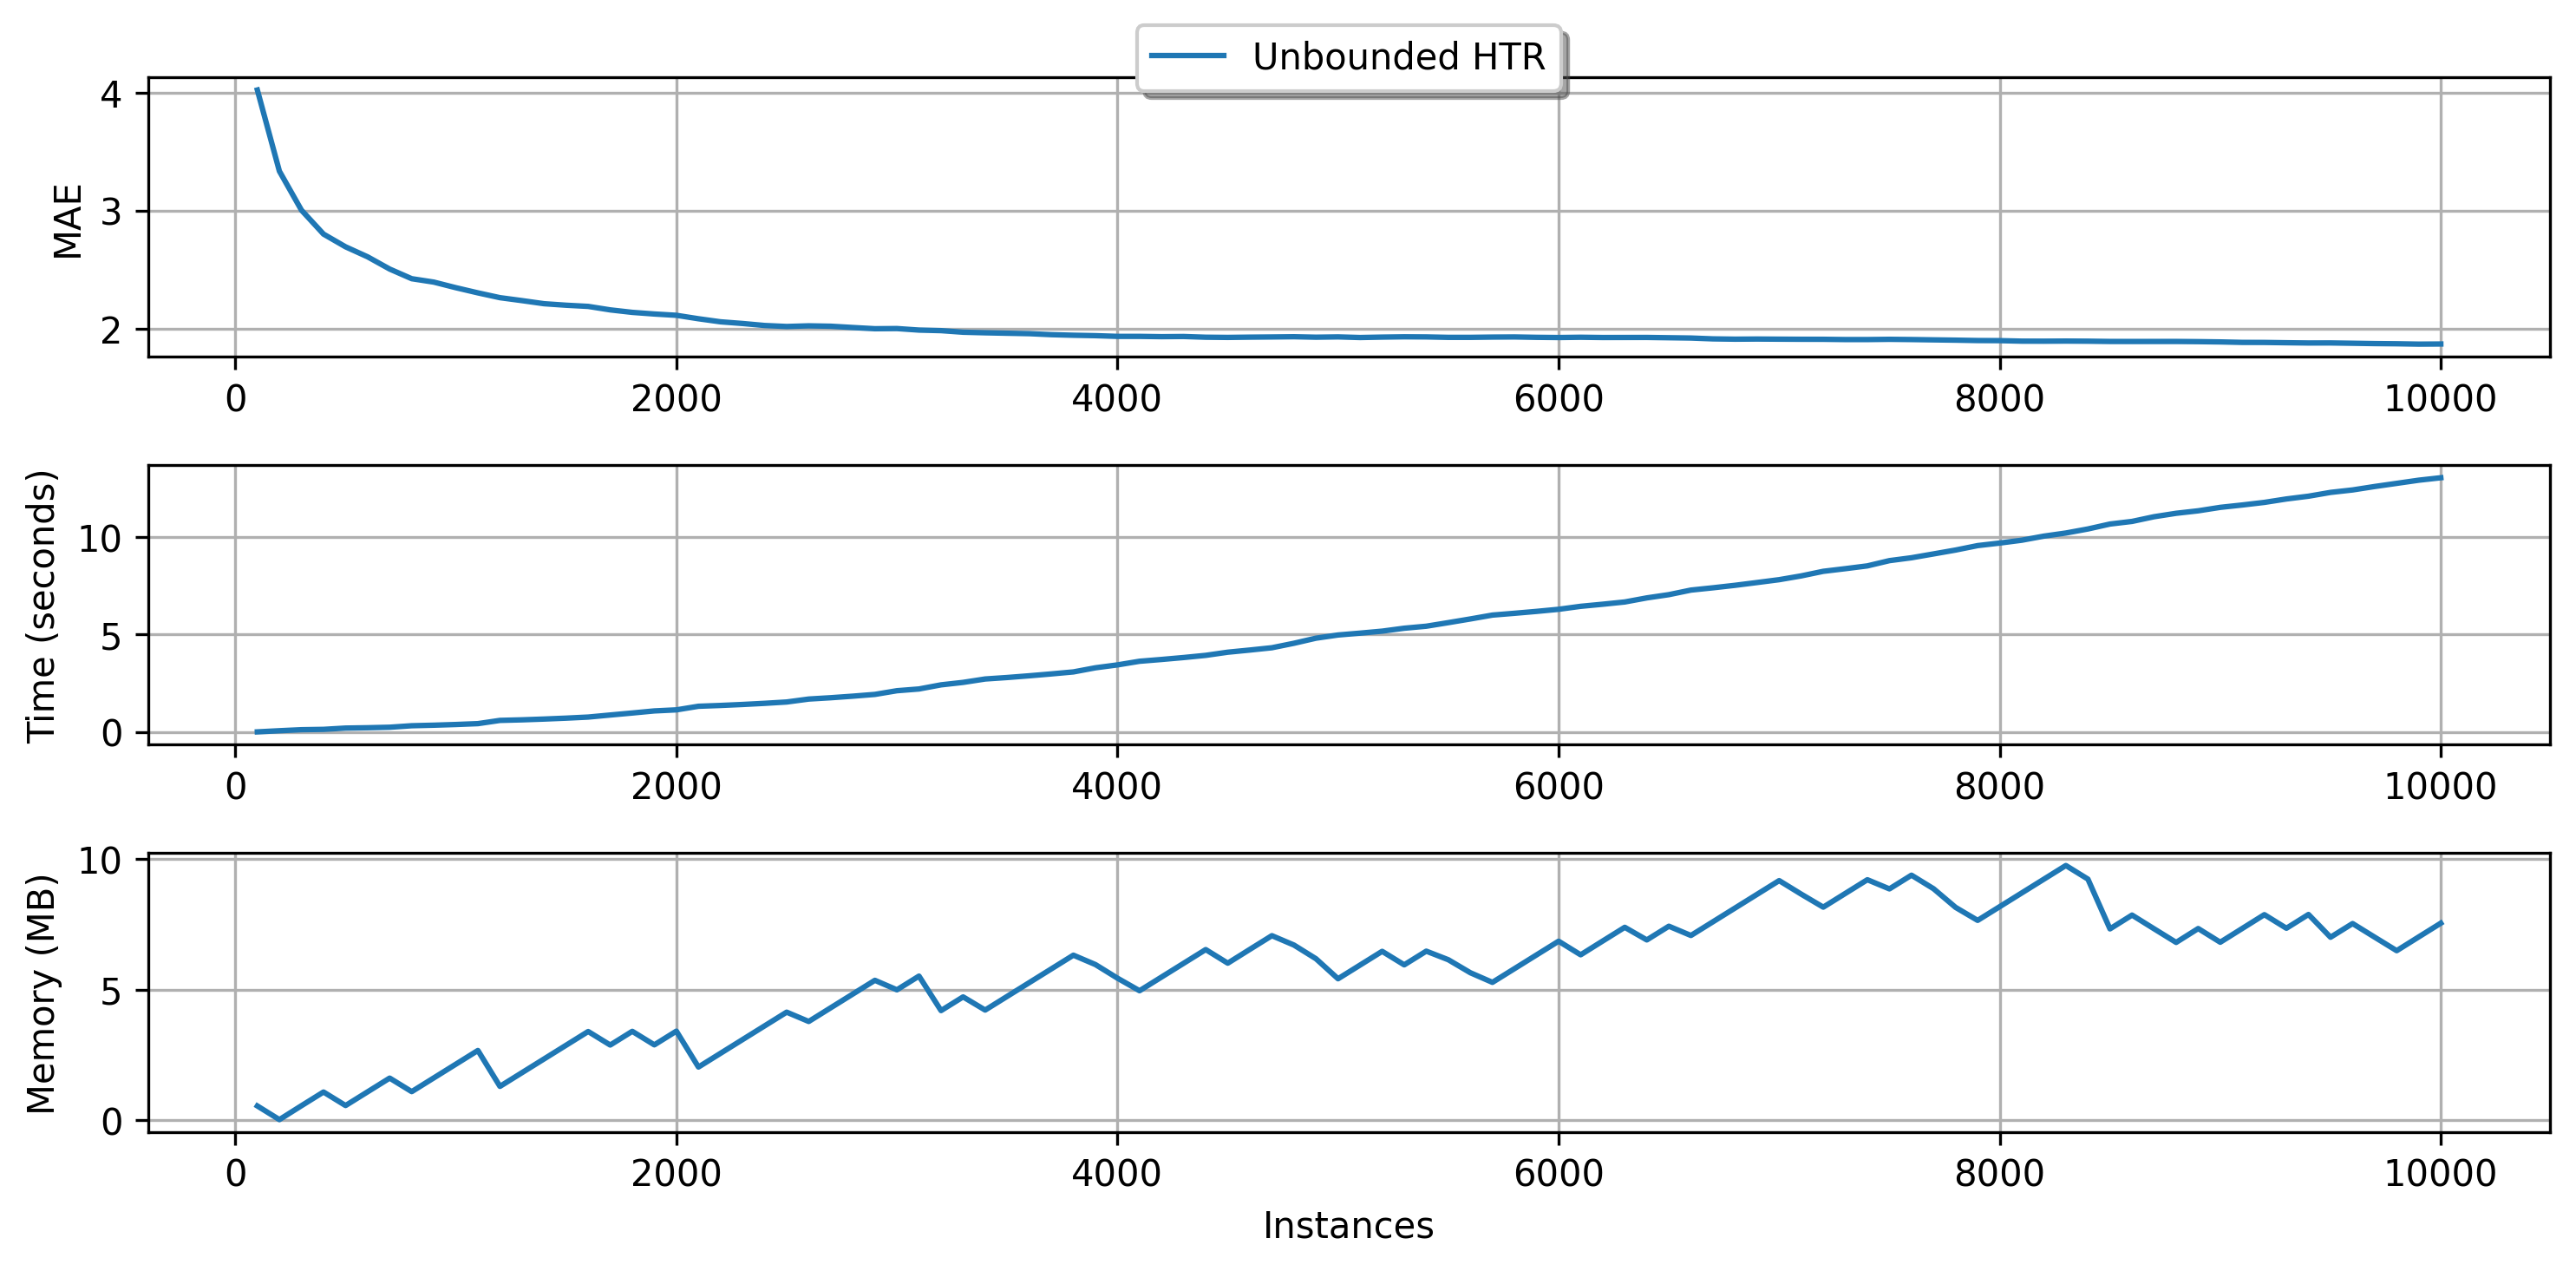

In [11]:
plot_performance(
    dataset = synth.Friedman(seed=42).take(10_000),
    metric = metrics.MAE(),
    models =
    {
        "Unbounded HTR": (
            preprocessing.StandardScaler() |
            tree.HoeffdingTreeRegressor(splitter=tree.splitter.EBSTSplitter())
        )
    }
)

# Eval_OML from spotRiver

## The OPM Data

In [12]:
import pandas as pd
from spotRiver.data.opm import fetch_opm
df = fetch_opm(include_categorical=True, data_home="data", return_df=True)
df.shape

(985862, 17)

In [13]:
df.isnull().sum()

Serial Number            0
List Year                0
Date Recorded            0
Town                     0
Address                  0
Assessed Value           0
Sale Amount              0
Sales Ratio              0
Property Type            0
Residential Type         0
Non Use Code             0
Assessor Remarks         0
OPM remarks              0
Location            790018
lon                 790030
lat                 790030
timestamp_rec            0
dtype: int64

In [14]:
for i in ["Location", "lon", "lat"]:
    df.dropna(subset=[i], inplace=True)
df.reset_index(inplace=True)
df.shape

(195832, 18)

In [15]:
df.isnull().sum()

index               0
Serial Number       0
List Year           0
Date Recorded       0
Town                0
Address             0
Assessed Value      0
Sale Amount         0
Sales Ratio         0
Property Type       0
Residential Type    0
Non Use Code        0
Assessor Remarks    0
OPM remarks         0
Location            0
lon                 0
lat                 0
timestamp_rec       0
dtype: int64

In [16]:
categorical_columns = [
            "Town",
            "Address",
            "Property Type",
            "Residential Type",
            "Non Use Code",
            "Assessor Remarks",
            "OPM remarks",
        ]

In [17]:
df = df.drop(columns=categorical_columns, axis=1)
df = df.drop(columns=["Location"], axis = 1)
df = df.drop(columns=["Date Recorded"], axis = 1)
df.shape

(195832, 9)

In [18]:
df.columns

Index(['index', 'Serial Number', 'List Year', 'Assessed Value', 'Sale Amount',
       'Sales Ratio', 'lon', 'lat', 'timestamp_rec'],
      dtype='object')

In [19]:
df.to_csv("opm.csv", index=False)

In [20]:
from spotRiver.data.generic import GenericData
opm_dataset = GenericData(filename="opm.csv",
                      directory=".",
                      target="Sale Amount",
                      n_features=7,
                      n_samples=195_832,
                      converters={'index': int,
                                  'Serial Number': int,
                                  'List Year': int,
                                  'Assessed Value': float,
                                  'Sale Amount': float,
                                  'Sales Ratio': float,
                                  'lon': float,
                                  'lat': float,
                                  'timestamp_rec': float},
                      parse_dates=None
                      # parse_dates={"Date Recorded": "%Y-%m-%d"}
                      )

In [21]:
for x,y in opm_dataset:
    print(x,y)
    break

{'index': 3, 'Serial Number': 10010, 'List Year': 2001, 'Assessed Value': 80010.0, 'Sales Ratio': 0.69573913, 'lon': -72.44156, 'lat': 41.86716, 'timestamp_rec': 1001894400.0} 115000.0


## Imputation with KNN

In [22]:
""" import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.impute import KNNImputer
hash_list = list(["Town", "Address", "Property Type",
       "Residential Type", "Non Use Code", "Assessor Remarks", "OPM remarks"])
for i in hash_list:
    df[i + "hash"] = pd.DataFrame(map(lambda x: str(hash(x)), df[i]))
df_num = df.drop(columns=hash_list)
df_num = df_num.drop(columns=["timestamp_rec", "Date Recorded", "Location"])

imputer = KNNImputer(n_neighbors=2, weights="uniform")
df_imp = imputer.fit_transform(df_num) """

' import pandas as pd\nfrom sklearn.compose import ColumnTransformer\nfrom sklearn.feature_extraction import FeatureHasher\nfrom sklearn.preprocessing import OneHotEncoder\nimport numpy as np\nfrom sklearn.impute import KNNImputer\nhash_list = list(["Town", "Address", "Property Type",\n       "Residential Type", "Non Use Code", "Assessor Remarks", "OPM remarks"])\nfor i in hash_list:\n    df[i + "hash"] = pd.DataFrame(map(lambda x: str(hash(x)), df[i]))\ndf_num = df.drop(columns=hash_list)\ndf_num = df_num.drop(columns=["timestamp_rec", "Date Recorded", "Location"])\n\nimputer = KNNImputer(n_neighbors=2, weights="uniform")\ndf_imp = imputer.fit_transform(df_num) '

In [23]:
""" from river import stream
params = {
     'converters': {'rating': float},
     'parse_dates': {'year': '%Y'}
}

dataset = stream.iter_csv('tv_shows.csv', target='rating', **params)
for x, y in dataset:
    print(x, y) """

" from river import stream\nparams = {\n     'converters': {'rating': float},\n     'parse_dates': {'year': '%Y'}\n}\n\ndataset = stream.iter_csv('tv_shows.csv', target='rating', **params)\nfor x, y in dataset:\n    print(x, y) "

## The GW Data

In [24]:
from spotRiver.data.generic import GenericData
dataset = GenericData(filename="UnivariateData.csv",
                      directory="/Users/bartz/data/",
                      target="Consumption",
                      n_features=1,
                      n_samples=51_706,
                      converters={"Consumption": float},
                      parse_dates={"Time": "%Y-%m-%d %H:%M:%S%z"})


In [25]:
for x,y in dataset:
    print(x,y)
    break

{'Time': datetime.datetime(2016, 12, 31, 23, 0, tzinfo=datetime.timezone.utc)} 10951.217


In [26]:
import matplotlib.pyplot as plt
import datetime as dt

from river import datasets
from river import evaluate
from river import metrics
from river import preprocessing  # we are going to use that later
from river.datasets import synth  # we are going to use some synthetic datasets too
from river import tree

In [27]:
from spotRiver.evaluation.eval_oml import eval_oml_iter_progressive
from spotRiver.evaluation.eval_oml import plot_oml_iter_progressive

* TODO: Change dataset

In [28]:
dataset = opm_dataset  # synth.Friedman(seed=42).take(10_000)

In [29]:
res_1 = eval_oml_iter_progressive(
    dataset = dataset,
    step = 10000,
    verbose = True,
    metric = metrics.MAE(),
    models =
    {
        "HTR + E-BST": (
            preprocessing.StandardScaler() | tree.HoeffdingTreeRegressor(
                splitter=tree.splitter.EBSTSplitter()
            )
        ),
        "HTR + TE-BST": (
            preprocessing.StandardScaler() | tree.HoeffdingTreeRegressor(
                splitter=tree.splitter.TEBSTSplitter()
            )
        ),
        "HTR + QO": (
            preprocessing.StandardScaler() | tree.HoeffdingTreeRegressor(
                splitter=tree.splitter.QOSplitter()
            )
        ),

    }
)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000


In [ ]:
plot_oml_iter_progressive(res_1)